In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/2021/졸업프로젝트/code')

In [ ]:
# !pip install emoji # 제목에 있는 이모티콘 출력시 사용

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 12.6MB/s 
     |████████████████████████████████| 460kB 51.3MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import warnings
warnings.filterwarnings(action='ignore')    # warning 무시하기

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 자연어처리 
from konlpy.tag import *
from gensim.models import Word2Vec, FastText
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

# LSTM 
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, Dense, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import to_categorical

## Load Data

In [ ]:
# 데이터 불러오기
data = pd.read_csv('data_including_subscriber_and_thumbnail.csv', usecols = [5,6], encoding='UTF-8')
data.head()

,views,preprocessed_title
0,30038.0,만 19세 연봉 1억 친구와 레스토랑 브이로그
1,29102.0,bbq 신메뉴 체고치 순살 먹어봄
2,25022.0,구찌 라이톤이랑 시계 후기
3,49551.0,엽기 로제떡볶이랑 허니 콤보 혼내줌
4,74348.0,어림도 없지 바로 마라탕 먹어버림


In [ ]:
# 조회수 1K 단위로 구간 나누기
data_cat = data.copy()           
print(data_cat.info())           
data_cat['views'] = (data_cat['views'].floordiv(1000)) 
data_cat          

# 1M 이후부터는 1,000,000 단위로 조회수 잘라야 할 것 같음 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101164 entries, 0 to 101163
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   views               101164 non-null  float64
 1   preprocessed_title  101164 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.5+ MB
None


,views,preprocessed_title
0,30.0,만 19세 연봉 1억 친구와 레스토랑 브이로그
1,29.0,bbq 신메뉴 체고치 순살 먹어봄
2,25.0,구찌 라이톤이랑 시계 후기
3,49.0,엽기 로제떡볶이랑 허니 콤보 혼내줌
4,74.0,어림도 없지 바로 마라탕 먹어버림
...,...,...
101159,137.0,현실남매 먹방하러 갔다가 진짜 싸웠습니다
101160,153.0,직업체험 dj예나 일일 매니저 월디페 world dj festival
101161,151.0,저의 슈퍼모델 친구들을 소개합니다
101162,177.0,현실남매 우리만 이런건가요 ? 남들이 이해 못하는 현실남매


In [ ]:
data_cat['views'] = data_cat['views'].astype('int64') # 데이터 int 타입으로 바꿔주기
data_cat

,views,preprocessed_title
0,30,만 19세 연봉 1억 친구와 레스토랑 브이로그
1,29,bbq 신메뉴 체고치 순살 먹어봄
2,25,구찌 라이톤이랑 시계 후기
3,49,엽기 로제떡볶이랑 허니 콤보 혼내줌
4,74,어림도 없지 바로 마라탕 먹어버림
...,...,...
101159,137,현실남매 먹방하러 갔다가 진짜 싸웠습니다
101160,153,직업체험 dj예나 일일 매니저 월디페 world dj festival
101161,151,저의 슈퍼모델 친구들을 소개합니다
101162,177,현실남매 우리만 이런건가요 ? 남들이 이해 못하는 현실남매


In [ ]:
Counter(data_cat['views']).most_common()[:10]   # 영상 수 가장 많은 30개

[(0, 10384),
 (1, 5293),
 (2, 3790),
 (3, 2898),
 (4, 2585),
 (5, 2262),
 (6, 1931),
 (7, 1714),
 (8, 1568),
 (9, 1431)]

In [ ]:
data_cat['views'].max() # 조회수 가장 높은 영상: 327914

327914

In [ ]:
import math # 구간 나눠주기 -> multiclass classification

for index, view in enumerate(data_cat['views']):
  # if view >= 50000:  data_cat['views'][index] =  50000
  if view >=10000:  data_cat['views'][index] =  10000
  # elif view >=5000:  data_cat['views'][index] =  5000
  elif view >=1000:  data_cat['views'][index] =  1000
  # elif view >=500:  data_cat['views'][index] =  500
  elif view >=100:  data_cat['views'][index] = 100
  # elif view >=50: data_cat['views'][index] =  50
  elif view >=10: data_cat['views'][index] = 10
  # elif view >=5: data_cat['views'][index] = 5
  # elif view >5: data_cat['views'][index] = math.floor(data_cat['views'][index]/5) * 5
  elif view >0: data_cat['views'][index] = 1

In [ ]:
data_cat['views'].max()

10000

In [ ]:
len(Counter(data_cat['views']))

6

In [ ]:
Counter(data_cat['views'])

Counter({0: 10384, 1: 23472, 10: 34318, 100: 27581, 1000: 5256, 10000: 153})

In [ ]:
label = Counter(data_cat['views']).keys()
label = sorted(label)
label

[0, 1, 10, 100, 1000, 10000]

In [ ]:
key = list(range(len(label)))

In [ ]:
# 구간 -> 인덱스, 인덱스 -> 구간 저장한 딕셔너리
cat_to_id = dict(zip(label, key))
id_to_cat = dict(zip(key, label))

## Preprocessing

### Morphology Analysis

In [ ]:
twitter = Okt()       # 트위터 형태소 분석기    
komoran = Komoran()   # Komoran 형태소 분석기
kkma = Kkma()         # kkma 형태소 분석기 

In [ ]:
# 말뭉치 만들기
def make_corpus(text):
    corpus = []
    for s in text:
      # corpus.append('/'.join(p) for p in komoran.pos(s)) 
      corpus.append(s.split()) 
    return corpus

In [ ]:
# 형태소 분석 후 조사 제거 X
def make_corpus_show_morph(text):
    corpus = []
    for s in text:
        corpus.append(['/'.join(p) for p in twitter.pos(s)]) 
    return corpus

In [ ]:
# 형태소 분석 후 조사 제거하기 
def make_corpus_morph(text):
    corpus = []
    for s in text:
        # title = ([p[0] for p in twitter.pos(s)])
        # corpus.append(' '.join(title))
        corpus.append([p[0] for p in twitter.pos(s)])
    return corpus

In [ ]:
corpus = make_corpus(data['preprocessed_title'])
corpus[0]

['만', '19세', '연봉', '1억', '친구와', '레스토랑', '브이로그']

In [ ]:
corpus = make_corpus_show_morph(data['preprocessed_title'])
corpus[:3]

[['만/Noun',
  '19/Number',
  '세/Noun',
  '연봉/Noun',
  '1억/Number',
  '친구/Noun',
  '와/Josa',
  '레스토랑/Noun',
  '브이/Noun',
  '로그/Noun'],
 ['bbq/Alpha',
  '신/Modifier',
  '메뉴/Noun',
  '체/Noun',
  '고치/Noun',
  '순/Modifier',
  '살/Noun',
  '먹어/Verb',
  '봄/Noun'],
 ['구찌/Noun', '라이/Noun', '톤/Noun', '이랑/Josa', '시계/Noun', '후기/Noun']]

In [ ]:
corpus = make_corpus_morph(data['preprocessed_title'])
corpus[:3]

[['만', '19', '세', '연봉', '1억', '친구', '와', '레스토랑', '브이', '로그'],
 ['bbq', '신', '메뉴', '체', '고치', '순', '살', '먹어', '봄'],
 ['구찌', '라이', '톤', '이랑', '시계', '후기']]

In [ ]:
data_cat['tokenized'] = corpus
data_cat.head()

,views,preprocessed_title,tokenized
0,10,만 19세 연봉 1억 친구와 레스토랑 브이로그,"[만, 19, 세, 연봉, 1억, 친구, 와, 레스토랑, 브이, 로그]"
1,10,bbq 신메뉴 체고치 순살 먹어봄,"[bbq, 신, 메뉴, 체, 고치, 순, 살, 먹어, 봄]"
2,10,구찌 라이톤이랑 시계 후기,"[구찌, 라이, 톤, 이랑, 시계, 후기]"
3,10,엽기 로제떡볶이랑 허니 콤보 혼내줌,"[엽기, 로, 제, 떡볶이, 랑, 허니, 콤보, 혼내, 줌]"
4,10,어림도 없지 바로 마라탕 먹어버림,"[어림, 도, 없지, 바로, 마라, 탕, 먹어, 버림]"


In [ ]:
data_cat.to_csv('titles_tokenized.csv', index = False)

### Train-Test-Split

In [ ]:
# 데이터프레임 불러오기
df = pd.read_csv('titles_tokenized.csv')

In [ ]:
df

,views,preprocessed_title,tokenized
0,10,만 19세 연봉 1억 친구와 레스토랑 브이로그,"['만', '19', '세', '연봉', '1억', '친구', '와', '레스토랑'..."
1,10,bbq 신메뉴 체고치 순살 먹어봄,"['bbq', '신', '메뉴', '체', '고치', '순', '살', '먹어', ..."
2,10,구찌 라이톤이랑 시계 후기,"['구찌', '라이', '톤', '이랑', '시계', '후기']"
3,10,엽기 로제떡볶이랑 허니 콤보 혼내줌,"['엽기', '로', '제', '떡볶이', '랑', '허니', '콤보', '혼내',..."
4,10,어림도 없지 바로 마라탕 먹어버림,"['어림', '도', '없지', '바로', '마라', '탕', '먹어', '버림']"
...,...,...,...
101159,100,현실남매 먹방하러 갔다가 진짜 싸웠습니다,"['현실', '남매', '먹방', '하러', '갔다가', '진짜', '싸웠습니다']"
101160,100,직업체험 dj예나 일일 매니저 월디페 world dj festival,"['직업', '체험', 'dj', '예나', '일일', '매니저', '월디페', '..."
101161,100,저의 슈퍼모델 친구들을 소개합니다,"['저', '의', '슈퍼모델', '친구', '들', '을', '소개', '합니다']"
101162,100,현실남매 우리만 이런건가요 ? 남들이 이해 못하는 현실남매,"['현실', '남매', '우리', '만', '이런', '건가', '요', '?', ..."


In [ ]:
X = df['tokenized']
X[:3]

0    ['만', '19', '세', '연봉', '1억', '친구', '와', '레스토랑'...
1    ['bbq', '신', '메뉴', '체', '고치', '순', '살', '먹어', ...
2                  ['구찌', '라이', '톤', '이랑', '시계', '후기']
Name: tokenized, dtype: object

In [ ]:
cat_to_id

{0: 0, 1: 1, 10: 2, 100: 3, 1000: 4, 10000: 5}

In [ ]:
# 조회수 구간 라벨 값으로 대체

views = data_cat['views'].map(cat_to_id)
data_cat['views'] = views
data_cat.head()

,views,preprocessed_title,tokenized
0,2,만 19세 연봉 1억 친구와 레스토랑 브이로그,"[만, 19, 세, 연봉, 1억, 친구, 와, 레스토랑, 브이, 로그]"
1,2,bbq 신메뉴 체고치 순살 먹어봄,"[bbq, 신, 메뉴, 체, 고치, 순, 살, 먹어, 봄]"
2,2,구찌 라이톤이랑 시계 후기,"[구찌, 라이, 톤, 이랑, 시계, 후기]"
3,2,엽기 로제떡볶이랑 허니 콤보 혼내줌,"[엽기, 로, 제, 떡볶이, 랑, 허니, 콤보, 혼내, 줌]"
4,2,어림도 없지 바로 마라탕 먹어버림,"[어림, 도, 없지, 바로, 마라, 탕, 먹어, 버림]"


In [ ]:
y = data_cat['views']
y[:3]

0    2
1    2
2    2
Name: views, dtype: int64

In [ ]:
y = to_categorical(y) # one hot encoding
y[:3]

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Tokenize & Embed

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
# 각 단어의 고유한 정수 출력
print(tokenizer.word_index) # 정수 클수록 등장 빈도수 낮음

{"'": 1, "'의'": 2, "'ep'": 3, "'tvpp'": 4, "'로그'": 5, "'브이'": 6, "'이'": 7, "'【'": 8, "'】'": 9, "'에'": 10, "'을'": 11, "'가'": 12, "'2'": 13, "'vlog'": 14, "'한'": 15, "'1'": 16, "'일상'": 17, "'화'": 18, "'는'": 19, "'은'": 20, "'x'": 21, "'heart'": 22, "'들'": 23, "'먹방'": 24, "'를'": 25, "'하는'": 26, "'3'": 27, "'tv'": 28, "'과'": 29, "'에서'": 30, "'eng'": 31, "'the'": 32, "'방송'": 33, "'with'": 34, "'메이킹'": 35, "'4'": 36, "'마이'": 37, "'로'": 38, "'a'": 39, "'live'": 40, "'와'": 41, "'of'": 42, "'린'": 43, "'music'": 44, "'도'": 45, "'캐치'": 46, "'show'": 47, "'나'": 48, "'에게'": 49, "'suit'": 50, "'댄스'": 51, "'인'": 52, "'tvn'": 53, "'으로'": 54, "'5'": 55, "'집'": 56, "'만들기'": 57, "'대'": 58, "'제시카'": 59, "'core'": 60, "'스브스'": 61, "'′'": 62, "'》'": 63, "'s'": 64, "'요'": 65, "'사랑'": 66, "'feat'": 67, "'카페'": 68, "'face'": 69, "'디바'": 70, "'내'": 71, "'《'": 72, "'10'": 73, "'7'": 74, "'ㅋㅋㅋㅋ'": 75, "'예고'": 76, "'my'": 77, "'고'": 78, "'다'": 79, "'영상'": 80, "'만'": 81, "'6'": 82, "'오'": 83, "'9'": 84, "'까지'": 85, 

In [ ]:
threshold = 2                         
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0                          # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0                        # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0                         # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68274
등장 빈도가 1번 이하인 희귀 단어의 수: 30348
단어 집합에서 희귀 단어의 비율: 44.450303190087006
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.929067915929049


In [ ]:
# 전체 단어 개수 중 빈도수 1이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 37927


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)

# keras tokenizer -> 텍스트 시퀀스 숫자 시퀀스로 변환
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Padding

발화문의 최대 길이 : 138
발화문의 평균 길이 : 19.063733303678443


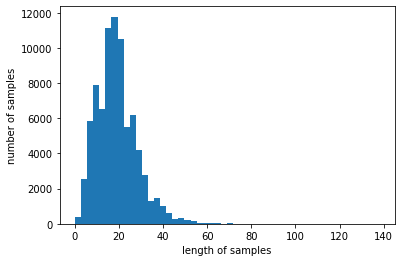

In [ ]:
print('제목의 최대 길이 :',max(len(l) for l in X_train))
print('제목의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 45
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 98.62351879996541


In [ ]:
# 모든 샘플의 길이 45으로 맞추기
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
X_train

array([[    0,     0,     0, ...,  4032,   181,   396],
       [    0,     0,     0, ...,  1244,     5,   100],
       [    0,     0,     0, ...,  1326,   658,   231],
       ...,
       [    0,     0,     0, ..., 23695,     3,   112],
       [    0,     0,     0, ...,    14,  1187,  2246],
       [    0,     0,     0, ..., 14301,   754,   396]], dtype=int32)

## LSTM Model


In [ ]:
model = Sequential([
    Embedding(vocab_size, 100),
    LSTM(128,  dropout= 0.2),
    Dense(6,activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         2888300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 6)                 774       
Total params: 3,006,322
Trainable params: 3,006,322
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model2 = Sequential([
    Embedding(vocab_size, 64),
    Bidirectional(LSTM(128, dropout = 0.2)),
    Dense(64, activation='relu'),
    Dense(6,activation='softmax')
])

print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 64)          2427328   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 390       
Total params: 2,641,798
Trainable params: 2,641,798
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('Bi-LSTM_class6.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=50, validation_data=(X_test, y_test))

Epoch 1/20
1619/1619 [==============================] - 89s 32ms/step - loss: 1.2404 - acc: 0.4615 - val_loss: 1.0126 - val_acc: 0.5665

Epoch 00001: val_acc improved from -inf to 0.56655, saving model to LSTM_class6.h5
Epoch 2/20
1619/1619 [==============================] - 51s 31ms/step - loss: 0.8579 - acc: 0.6453 - val_loss: 1.0008 - val_acc: 0.5716

Epoch 00002: val_acc improved from 0.56655 to 0.57164, saving model to LSTM_class6.h5
Epoch 3/20
1619/1619 [==============================] - 51s 32ms/step - loss: 0.7028 - acc: 0.7188 - val_loss: 1.0395 - val_acc: 0.5751

Epoch 00003: val_acc improved from 0.57164 to 0.57510, saving model to LSTM_class6.h5
Epoch 4/20
1619/1619 [==============================] - 51s 32ms/step - loss: 0.5706 - acc: 0.7764 - val_loss: 1.1314 - val_acc: 0.5645

Epoch 00004: val_acc did not improve from 0.57510
Epoch 5/20
1619/1619 [==============================] - 51s 31ms/step - loss: 0.4566 - acc: 0.8263 - val_loss: 1.2874 - val_acc: 0.5540

Epoch 0000

In [ ]:
model2.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['acc'])
history = model2.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
1265/1265 [==============================] - 47s 31ms/step - loss: 1.2482 - acc: 0.4542 - val_loss: 1.0161 - val_acc: 0.5607

Epoch 00001: val_acc did not improve from 0.57960
Epoch 2/20
1265/1265 [==============================] - 39s 31ms/step - loss: 0.8602 - acc: 0.6460 - val_loss: 1.0119 - val_acc: 0.5662

Epoch 00002: val_acc did not improve from 0.57960
Epoch 3/20
1265/1265 [==============================] - 38s 30ms/step - loss: 0.6749 - acc: 0.7324 - val_loss: 1.0903 - val_acc: 0.5697

Epoch 00003: val_acc did not improve from 0.57960
Epoch 4/20
1265/1265 [==============================] - 39s 31ms/step - loss: 0.5329 - acc: 0.7944 - val_loss: 1.1708 - val_acc: 0.5605

Epoch 00004: val_acc did not improve from 0.57960
Epoch 5/20
1265/1265 [==============================] - 39s 31ms/step - loss: 0.4270 - acc: 0.8386 - val_loss: 1.2995 - val_acc: 0.5491

Epoch 00005: val_acc did not improve from 0.57960
Epoch 6/20
1265/1265 [==============================] - 39s 31ms/

In [ ]:
loaded_model = load_model('Bi-LSTM_class6_0.57960.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

633/633 [==============================] - 4s 5ms/step - loss: 0.9879 - acc: 0.5796

 테스트 정확도: 0.5796


In [ ]:
pred = np.argmax(loaded_model.predict(X_test), axis=-1)

In [ ]:
y_test[0]

array([0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
len(y_test)

20233

In [ ]:
true = [np.argmax(y_test[i]) for i in range(len(y_test))]

**조회수 예측 카테고리**<br>
0: under 1K<br>
1: 1K 이상, 10K 미만<br>
2: 10K 이상, 100K 미만<br>
3: 100K 이상, 1000K(1M) 미만<br>
4: 1000K(1M) 이상, 10000K(5M) 미만<br>
5: 10000K(5M) 이상

In [ ]:
# Classification Report
from sklearn.metrics import classification_report
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.66      0.58      0.62      2096
           1       0.54      0.58      0.56      4705
           2       0.55      0.58      0.57      6881
           3       0.60      0.63      0.61      5497
           4       0.62      0.25      0.36      1021
           5       0.29      0.06      0.10        33

    accuracy                           0.58     20233
   macro avg       0.54      0.45      0.47     20233
weighted avg       0.58      0.58      0.57     20233



In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_mat=confusion_matrix(true, pred)  # confusion matrix 계산
# plt.figure(figsize = (14, 8))
# sns.heatmap(conf_mat, annot=True) # heatmap으로 나타내기

# Class 별 Accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)  # 각 클래스 별 accuracy 담은 list
class_accuracy = pd.DataFrame(class_accuracy, columns = ['Accuracy']) # dataframe 화하기

In [ ]:
class_accuracy.insert(0, 'View Category', list(cat_to_id.keys())[:20])
class_accuracy

,View Category,Accuracy
0,0,57.824427
1,1,57.725824
2,10,58.000291
3,100,62.870657
4,1000,25.367287
5,10000,6.060606
